In [272]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import scipy.stats as stats
import copy
import keras

#for importing data
import torchvision
import torchvision.transforms as T
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset, Subset, Dataset
import pandas as pd

#for data visualization
import seaborn as sns
import matplotlib.pyplot as plt
# from IPython.display import set_matplotlib_formats
# set_matplotlib_formats('svg')
from skimage.draw import line_aa

In [273]:
#GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [274]:
# Transformations
# Step 0 : normalize
# Step 1 : convert to tensor
transform = T.Compose([
    T.ToTensor(),
    T.Normalize(
        mean=[0.5],
        std =[0.5]
        # mean=[0.5,0.5,0.5],
        # std =[0.5,0.5,0.5]
        )
    #T.Resize()
    #T.RandomHorizontalFlip(p=0.5)
])

In [275]:
nImages = 10000
imgSize = 30

x   = np.linspace(-4,4,imgSize)
X,Y = np.meshgrid(x,x)


# initialize tensors containing images and labels
images = torch.zeros(nImages,1,imgSize,imgSize)
labels = torch.zeros(nImages,1)
horiz = 0

for i in range(nImages):

    # create the gaussian random offset
    # ro = 2*np.random.randn(2)
    
    # create the gaussian random width
    # width = np.random.rand()/.6 + 1.8 
    
    # Create the gaussian equation with RO & Width 
    # G  = np.exp( -( (X-ro[0])**2 + (Y-ro[1])**2) / (2*width**2) )

    # add noise ... 
    amountOfNoise = 1/5
    G  = np.random.randn(imgSize,imgSize)*amountOfNoise

    # add a random bar randomly
    barWidth = np.random.choice(np.arange(1,5))
    barStartPoint = np.random.choice(np.arange(1,imgSize-barWidth))
    if np.random.randn()>0:
        G[barStartPoint:barStartPoint+barWidth,] = 1
        horiz = 1
    else:
        G[:,barStartPoint:barStartPoint+barWidth] = 1
        horiz = 0

    # add to the tensor
    images[i,:,:,:] = torch.Tensor(G).view(1,imgSize,imgSize)
    labels[i,:] = torch.Tensor( [horiz] )



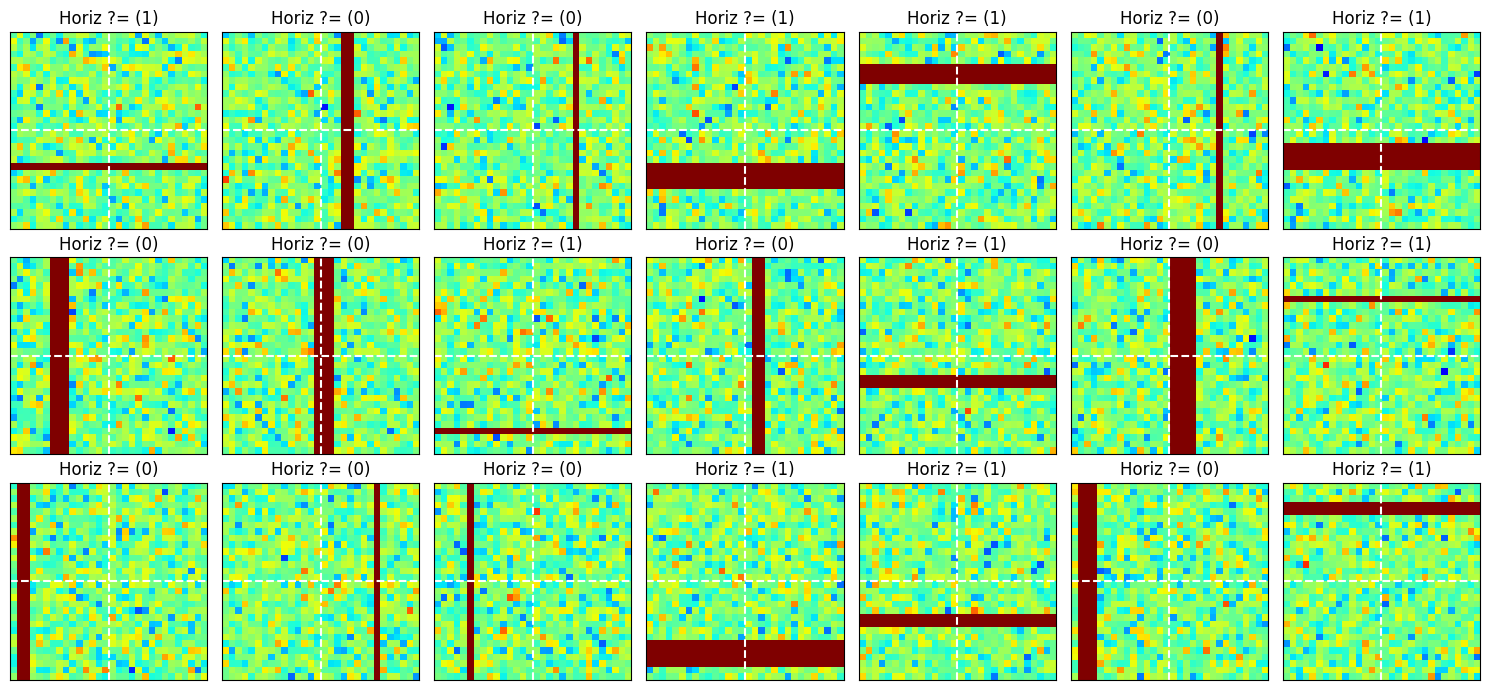

In [276]:

# visualize some images
fig,axs = plt.subplots(3,7,figsize=(15,7))

for i,ax in enumerate(axs.flatten()):
    whichpic = np.random.randint(nImages)
    G = np.squeeze( images[whichpic,:,:] )
    ax.imshow(G,vmin=-1,vmax=1,cmap='jet',extent=[-4,4,-4,4],origin='upper')
    # ax.imshow(G,vmin=-1,vmax=1,cmap='jet')#,extent=[-4,4,-4,4],origin='upper')
    ax.set_title(f'Horiz ?= ({labels[whichpic,0]:.0f})')
                 #,{labels[whichpic,1]:.0f}), W={labels[whichpic,2]:.0f}')
    ax.plot([-4,4],[0,0],'w--')
    ax.plot([0,0],[-4,4],'w--')
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()


In [277]:
# Step2: use scikit learn to split the data
train_data, test_data, train_labels, test_labels = train_test_split(images, labels, test_size=0.1)

In [278]:
# Custom dataset to apply transform
class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label
# class CustomDataset(Dataset):
#     def __init__(self, images, labels , transform=None):

#         # check that sizes of data and labels match
#         assert all(images[0].size(0)==t.size(0) for t in images), "Size mismatch between tensors"
#         assert all(labels[0].size(0)==t.size(0) for t in labels), "Size mismatch between tensors"
        
#         # assign inputs
#         self.images   = images
#         self.labels   = labels
#         self.transform = transform

#     # what to do when someone wants and item from the dataset
#     def __getitem__(self, index): 

#         # return transformed version of x if there are transforms
#         if self.transform:
#             image = self.transform(self.images[0][index])
#             label = self.transform(self.labels[0][index])
#         else:
#             image = self.images[0][index]
#             label = self.labels[0][index]
            
#         return image, label # return the (data,label) tuple

#     def __len__(self):
#         return self.images[0].size(0)



In [279]:
# Step 3: Convert into PyTorch Datasets
# train_data = TensorDataset(train_data, train_labels)
# test_data  = TensorDataset(test_data , test_labels)
train_dataset = CustomDataset(train_data, train_labels, transform=transform)
test_dataset  = CustomDataset(test_data, test_labels, transform=transform)

In [280]:
test_data.data.shape[0]

1000

In [281]:
train_data.data.shape[2]

30

In [282]:
# Step 4: Translate into dataloader objects
batchsize    = 32
train_loader = DataLoader(train_dataset, batch_size=batchsize, shuffle=True, drop_last=True)
test_loader  = DataLoader(test_dataset,  batch_size=batchsize)
# test_loader  = DataLoader(test_dataset,  batch_size=test_data.data.shape[0])

In [283]:
# Create the Deep Learning Model
def createTheNet(printtoggle=False):
    class cnnClassNet(nn.Module):
        def __init__(self):
            super().__init__()
            
            self.print = printtoggle
            
            imgSize = (train_data.data.shape[2]) #30
            print('imgsize= ',imgSize)
            inChans  = 1 # RGB
            outChans = 64 # feature maps # of kernels
            krnSize  = 3 # odd number
            padding  = 0 # square if single input
            stride   = 1 # use maxpool instead of stride ... so stride = 1
            
            
            # First Convolution Layer
            #Conv2d(in_channels # of channels,
            #       out_channels # feature maps kernels, 
            #       kernel_size, 
            #       stride,
            #       padding  )
            self.conv1  = nn.Conv2d(inChans,outChans,krnSize, stride, padding)
            self.bnorm1 = nn.BatchNorm2d(outChans) # 64
            outputSize = np.floor( (imgSize+2*padding-krnSize)/stride ) + 1
            outputSize = np.floor(outputSize/2) # pool
            # output size = np.floor( (imsize[0]+2*padding-krnSize)/stride[0] ) + 1
            # output size = floor( (30 + 2*0 - 3) / 1 ) + 1 = 28
            # output size = 28/2 = 14 b/c of pool
            
            # Second Convolution Layer
            self.conv2  = nn.Conv2d(outChans,outChans*2,krnSize, stride, padding)
            self.bnorm2 = nn.BatchNorm2d(outChans*2) # 128
            outputSize = np.floor( (outputSize+2*padding-krnSize)/stride ) + 1
            outputSize = np.floor(outputSize/2) # pool
            # output size = floor( (14 + 2*0 - 3) / 1 ) + 1 = 12
            # output size = 12/2 = 6 b/c of pool
            
            # Third Convolution Layer
            self.conv3  = nn.Conv2d(outChans*2,outChans*2*2,krnSize, stride, padding)
            self.bnorm3 = nn.BatchNorm2d(outChans*2*2) # 256
            outputSize = np.floor( (outputSize+2*padding-krnSize)/stride ) + 1
            outputSize = np.floor(outputSize/2) # pool
            # output size = floor( (6 + 2*0 - 3) / 1 ) + 1 = 4
            # output size = 4/2 = 2 b/c of pool

            ### ------- Linear Layer ------- ###
            # self.fc1 = nn.Linear(flattened_size,200) #1024, 256
            flattened_size = (outputSize**2) * (outChans*2*2)
            # print(flattened_size)
            self.fc1 = nn.Linear(int(flattened_size),200) #1024, 256
            self.fc2 = nn.Linear(200,20)
            self.fc3 = nn.Linear(20,1)
            
        def forward(self, x):
            
            if self.print: print(f'Input: {list(x.shape)}')
            
            #first conv -> maxpool -> batchnorm -> relu
            #CPBR block
            x = F.max_pool2d( self.conv1(x), 2)
            x = F.leaky_relu( self.bnorm1(x)  )
            if self.print: print(f'First conv: {list(x.shape)}')
            
            x = F.max_pool2d( self.conv2(x), 2)
            x = F.leaky_relu( self.bnorm2(x)  )
            if self.print: print(f'Second conv: {list(x.shape)}')

            x = F.max_pool2d( self.conv3(x), 2)
            x = F.leaky_relu( self.bnorm3(x)  )
            if self.print: print(f'Third conv: {list(x.shape)}')

            #reshape for linear layer
            nUnits = x.shape.numel()/x.shape[0]
            x = x.view(-1, int(nUnits))
            if self.print: print(f'Vectorized: {list(x.shape)}')
            
            # Linear layers
            x = F.leaky_relu( self.fc1(x)   )
            x = F.dropout(x, p=0.5, training=self.training)
            if self.print: print(f'fc1: {list(x.shape)}')
            
            x = F.leaky_relu( self.fc2(x)   )
            x = F.dropout(x, p=0.5, training=self.training)
            if self.print: print(f'fc2: {list(x.shape)}')
            
            x = self.fc3(x)
            if self.print: print(f'Final Output: {list(x.shape)}')
            
            
            return x
        
    modelInstance = cnnClassNet().to(device)
    
    lossfun = nn.BCEWithLogitsLoss()
    
    optimizer = torch.optim.Adam(modelInstance.parameters(), lr=0.001)
                                #weight_decay=1e-4)#, betas=(0.9, 0.999), eps=1e-8)
    
    return modelInstance, lossfun, optimizer

In [284]:
#Test with 1 batch
net2, lossfun2, optimizer2 = createTheNet(True)

X, y = next(iter(train_loader))

X = X.to(device)
y = y.to(device)

yHat = net2(X)

#check size of output
print(yHat.shape)
print(y.shape)

#compute the loss
loss = lossfun2(yHat, y)
print(loss)

TypeError: object of type 'int' has no len()

In [ ]:
# Train the Model

def trainTheModel(trainedModel, lossfun, optimizer, epochs=20):
    
    #number of epochs to train
    numepochs = epochs
    trainedModel.train()
        
    #initialize losses & accuracy
    trainLoss   = torch.zeros(numepochs)
    trainAcc = []
    testLoss   = torch.zeros(numepochs)
    testAcc  = []

    for epochi in range(numepochs):
        
        #batch loss & accuracy
        trainBatchLoss = []
        trainBatchAcc  = []
        
        #loop over mini-batches
        for X,y in train_loader:
            
            # push data to GPU
            X = X.to(device)
            y = y.to(device)
            
            #Forward pass & loss
            yHat = trainedModel(X)
            loss = lossfun(yHat, y)
            
            #backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            #loss from this batch
            trainBatchLoss.append(loss.item())
            
            #accuracy from this batch -> for BCE sigmoid
            trainMatches = torch.sigmoid(yHat) > 0.5 ##
            trainMatchesNumeric = trainMatches.float()
            trainBatchAcc.append( torch.mean( (trainMatchesNumeric == y.float()).float() ).item() )

            # batchMathces = (torch.abs(yHat - y)).detach().cpu().float().numpy()
            # batchAcc.append(( batchMathces < 0.5))
            
            # accuracy from this batch for categorical data
            # accMatches = torch.argmax(yHat, axis=1)
            # accMatchesNumeric = (accMatches == y).float()
            # trainBatchAcc.append( torch.mean(accMatchesNumeric).item() )
        
        #average accuracy across mini-batches
        trainAcc.append(100 * np.mean((trainBatchAcc)))
        
        #average losses across all mini-batches
        trainLoss[epochi] = np.mean(trainBatchLoss)
        
        ################################
        # eval mode
        # do not use dropout 
        # do not use batch normalization instead use avg
        trainedModel.eval()

        #batch loss & accuracy
        testBatchLoss = []
        testBatchAcc  = []
        #final forward pass for Test Accuracy
        # X,y = next(iter(dev_loader))
        for X, y in test_loader:
            
            # push data to GPU
            X = X.to(device)
            y = y.to(device)

            #forward pass & loss
            with torch.no_grad():
                yHat = trainedModel(X)
                loss = lossfun(yHat, y)
            
            #batch loss    
            testBatchLoss.append(loss.item())
            
            #batch acc
            testMatches = torch.sigmoid(yHat) > 0.5 
            testMatchesNumeric = testMatches.float()
            testAcc.append(100 * torch.mean( (testMatchesNumeric == y.float()).float() ).item() )


        #compute the test accuracy for categorical data
        testLoss[epochi] = ( np.mean(testBatchLoss) )
        
        testAcc.append(100*np.mean(testBatchAcc))

        # testMatches = (torch.abs(yHat - y)).detach().cpu().float().numpy()
        # testMatchesNumeric = (testMatches < 1)
        # testAcc.append(100 * np.mean( testMatchesNumeric ) )

        #compute the test accuracy for BCE sigmoid
        
        # Acc for categorization
        # accMatches = torch.argmax(yHat, axis=1)
        # accMatchesNumeric = (accMatches == y).float()
        # testBatchAcc.append( torch.mean(accMatchesNumeric).item() )

    # return losses, trainedModel
    # return trainAcc, losses, trainedModel
    return trainAcc, trainLoss, testAcc, testLoss, trainedModel

In [ ]:
# Test the training code that it has NO ERRORS
epochs=1
myModelInstance2, lossfun2, optimizer2 = createTheNet()
# losses2, trainedModel2 = trainTheModel(myModelInstance2, lossfun, optimizer, epochs)
# trainAcc2, losses2, trainedModel2 = trainTheModel(myModelInstance2, lossfun, optimizer, epochs)
trainAcc2, trainLoss2, testAcc2, testLoss2, trainedModel2 = trainTheModel(myModelInstance2, lossfun2, optimizer2, epochs)

imgsize=  30


c:\Users\elmog\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\elmog\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [ ]:
# Train the Model
myModelInstance, lossfun, optimizer = createTheNet()
trainAcc, trainLoss, testAcc, testLoss, trainedModel = trainTheModel(myModelInstance, lossfun, optimizer)
# trainAcc, losses, trainedModel = trainTheModel(myModelInstance, lossfun, optimizer)
# trainAcc, testAcc, losses, trainedModel = trainTheModel(myModelInstance, lossfun, optimizer)

imgsize=  30


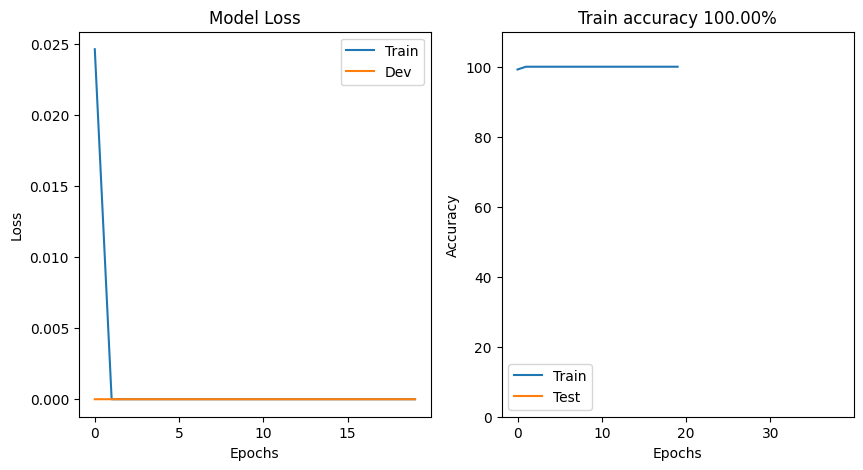

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(10,5))

ax[0].plot(trainLoss, label='Train')
ax[0].plot(testLoss, label='Dev')
ax[0].legend()
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Model Loss')

ax[1].plot(trainAcc, label='Train')
ax[1].plot(testAcc, label='Test')
ax[1].legend()
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].set_title(f'Train accuracy {trainAcc[-1]:.2f}%')
ax[1].set_ylim([0,110])

plt.show()

In [ ]:
# imgSize = 31
# nImages = 10000

# x   = np.linspace(-4,4,imgSize)
# X,Y = np.meshgrid(x,x)

# img = np.zeros((imgSize, imgSize), dtype=np.uint8)
# y = ax

# # rr, cc, val = line_aa(0, 0, 0, 30) # Horizontal #start here, -> x2 increase -> +ve slope
# # rr, cc, val = line_aa(0, 0, 30, 30) # +ve slope -> y2 
# # rr, cc, val = line_aa(0, 0, 30, 0) # vertical 
# # rr, cc, val = line_aa(0, 30, 30, 0) # -ve slope

# # rr, cc, val = line_aa(30, 30, 0, 0)
# img[rr, cc] = val * 255
# fig,ax = plt.subplots(1,2,figsize=(10,5))
# # ax[0].set_xlim([-30,30])
# ax[0].imshow(img, origin="lower")


In [ ]:
testAcc

[100.0,
 nan,
 100.0,
 nan,
 100.0,
 nan,
 100.0,
 nan,
 100.0,
 nan,
 100.0,
 nan,
 100.0,
 nan,
 100.0,
 nan,
 100.0,
 nan,
 100.0,
 nan,
 100.0,
 nan,
 100.0,
 nan,
 100.0,
 nan,
 100.0,
 nan,
 100.0,
 nan,
 100.0,
 nan,
 100.0,
 nan,
 100.0,
 nan,
 100.0,
 nan,
 100.0,
 nan]